In [27]:
%matplotlib notebook
from utils.converter import *
import math
from scipy.fft import fft, ifft, fftfreq
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('support-files/qubit.mplstyle')

FLUX = float
FLUX_NUMBER = int
cos = np.cos
sin = np.sin
pi = np.pi

fF = 10 ** (-15)
c = 10**(-10) #F/m Capacitance on interface
h = 6.64 * 10**(-34)
e = 1.6 * 10**(-19)
um = 10**(-6)
GHz = 10**(9)
kOhm = 10**3
Rq = 6.484*kOhm
Delta = 3.1*10**(-23) # Superconducting delta
Phi0 = h/(2 * e)
Gauss = 10**(-4) # Gauss to Wb/m²
kHz = 10**3
twoPi = 2*np.pi
MHz = 10**6

# Pipepline runthrough
- Take the signal on the SPA at each stage in order to see the signal and noise
- Will choose a pi pulse of 16ns at 5dBm

In [66]:
# Power from the photon source
w0 = 6.9 * GHz
T1 = 50 * ns

signal_1 = hbar * w0 / T1
signal_1_dBm = W_to_dBm(signal_1)

signal_1_dBm

-138.3613270258886

In [67]:
# Quinstar ciculator @ 13mK
T = 13 / 1000
gain = 0

noise = 4 * kb * T
noise_dBm = W_to_dBm(noise)

signal_2_dBm = signal_1_dBm + gain
noise_2_dBm = noise_dBm

signal_2_dBm, noise_2_dBm

(-138.3613270258886, -211.44117569963964)

In [105]:
# Cryogenic amplifier @ 5K noise from datasheet
T = 5
gain = 37
CORRECTION = 3
noise_temp = 4 * kb * T

signal_3_dBm = signal_2_dBm + gain
noise_3_dBm = W_to_dBm(
    (dBm_to_W(noise_2_dBm) + noise_temp) * 10**(gain/10)
) - CORRECTION

signal_3_dBm, noise_3_dBm

(-101.36132702588861, -151.5796321765775)

<IPython.core.display.Javascript object>


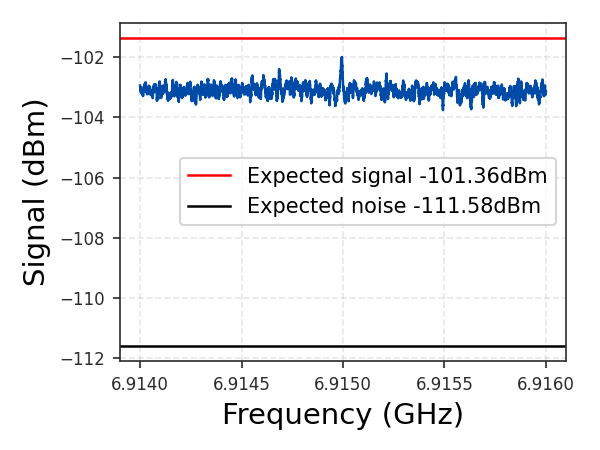

In [106]:
# Measurement - cannot measure noise due to resolution of SPA
RBW = 10*kHz
FILENAME = "C:/ExperimentBlue/2021-08_photon-source/Ay_42_tracking-signal_stage1.txt"

noise = W_to_dBm(dBm_to_W(noise_3_dBm) * RBW) 
signal = signal_3_dBm

with open(FILENAME) as fin:
    data = np.loadtxt(fin)
    
fix, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.axhline(signal, color="red", label=f"Expected signal {signal:.2f}dBm")
ax.axhline(noise, color="black", label=f"Expected noise {noise:.2f}dBm")
ax.plot(data[:, 0], data[:, 1])
ax.set_xlabel("Frequency (GHz)")
ax.set_ylabel("Signal (dBm)")
ax.legend()
plt.tight_layout()

In [107]:
# Amplifiers minicircuit
gain = 32
# Noise taken from calibration instead of temperature: jul-2021_-100dBm_spa_minicircuit
T = 295
noise_temp = W_to_dBm(4*kb*T)
noise_per_10kHz =-100
noise_calibration = W_to_dBm(dBm_to_W(noise_per_10kHz) / (10*kHz))
print(f"Calibrated noise: {noise}dBm/Hz, temperature noise: {noise_temp}dBm/Hz")

signal_4_dBm = signal_3_dBm + gain
noise_4_dBm = W_to_dBm(
    (dBm_to_W(noise_3_dBm)) * 10**(gain/10) + dBm_to_W(noise_calibration)
)

signal_4_dBm, noise_4_dBm

Calibrated noise: -111.57963217657749dBm/Hz, temperature noise: -167.88238906292636dBm/Hz


(-69.36132702588861, -119.54038722444542)

<IPython.core.display.Javascript object>


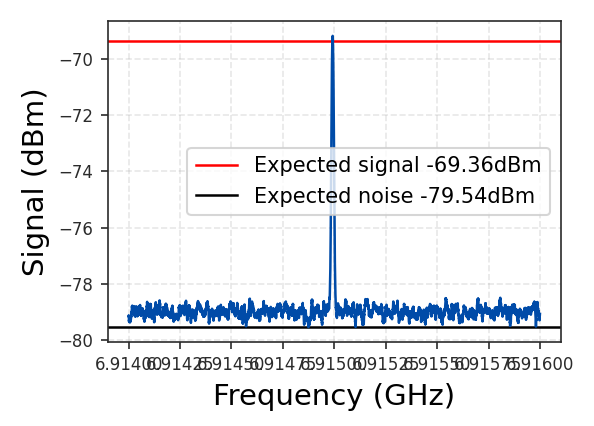

(-69.36132702588861, -79.54038722444542)

In [108]:
# Measurement
RBW = 10*kHz
FILENAME = "C:/ExperimentBlue/2021-08_photon-source/Ay_42_tracking-signal_stage2.txt"

noise = W_to_dBm(dBm_to_W(noise_4_dBm) * RBW) 
signal = signal_4_dBm

with open(FILENAME) as fin:
    data = np.loadtxt(fin)
    
fix, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.axhline(signal, color="red", label=f"Expected signal {signal:.2f}dBm")
ax.axhline(noise, color="black", label=f"Expected noise {noise:.2f}dBm")
ax.plot(data[:, 0], data[:, 1])
ax.set_xlabel("Frequency (GHz)")
ax.set_ylabel("Signal (dBm)")
ax.legend()
plt.tight_layout()

signal, noise

In [153]:
# Amplifiers a0X (we will also add a second one)
gain = 27
# Noise taken from calibration instead of temperature: spa-single-a0x
T = 295
noise_temp = W_to_dBm(4*kb*T)
noise_per_10kHz =-100
noise_calibration = W_to_dBm(dBm_to_W(noise_per_10kHz) / (10*kHz))
print(f"Calibrated noise: {noise}dBm/Hz, temperature noise: {noise_temp}dBm/Hz")

signal_5_dBm = signal_4_dBm + gain
noise_5_dBm = W_to_dBm(
    (dBm_to_W(noise_4_dBm)) * 10**(gain/10) + dBm_to_W(noise_calibration)
)

signal_5_dBm, noise_5_dBm

Calibrated noise: -53.54028909075595dBm/Hz, temperature noise: -167.88238906292636dBm/Hz


(-42.36132702588861, -92.54030927390396)

<IPython.core.display.Javascript object>


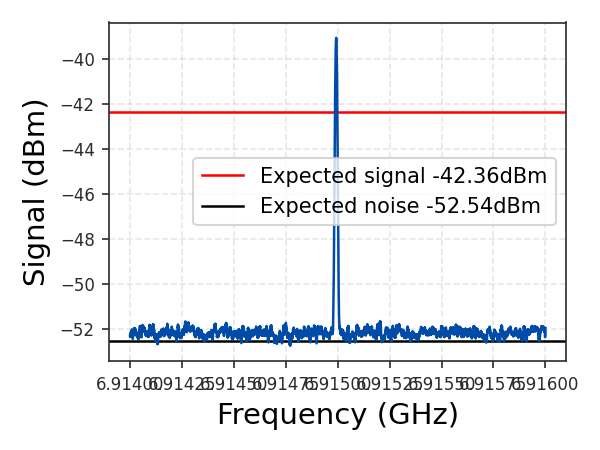

In [154]:
# Measurement
RBW = 10*kHz
FILENAME = "C:/ExperimentBlue/2021-08_photon-source/Ay_42_tracking-signal_stage3.txt"

noise = W_to_dBm(dBm_to_W(noise_5_dBm) * RBW) 
signal = signal_5_dBm

with open(FILENAME) as fin:
    data = np.loadtxt(fin)
    
fix, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.axhline(signal, color="red", label=f"Expected signal {signal:.2f}dBm")
ax.axhline(noise, color="black", label=f"Expected noise {noise:.2f}dBm")
ax.plot(data[:, 0], data[:, 1])
ax.set_xlabel("Frequency (GHz)")
ax.set_ylabel("Signal (dBm)")
ax.legend()
plt.tight_layout()

Therefore noise is expected to be
- In W: 94dBm-in-watts * RBW-in-Hz
- In dBm: $-93 + 10 * log_{10}(\Delta{f})$ dBm

Next we perform downconversion of the signal. 
- Signal @ 6.915GHz
- Mix with generator @ 6.9151 GHZ (100kHz offset)
- 13 dBm refference signal

From graph we can see that signal is succesfully downconverted, with and amplitude loss of 15dBm

<IPython.core.display.Javascript object>


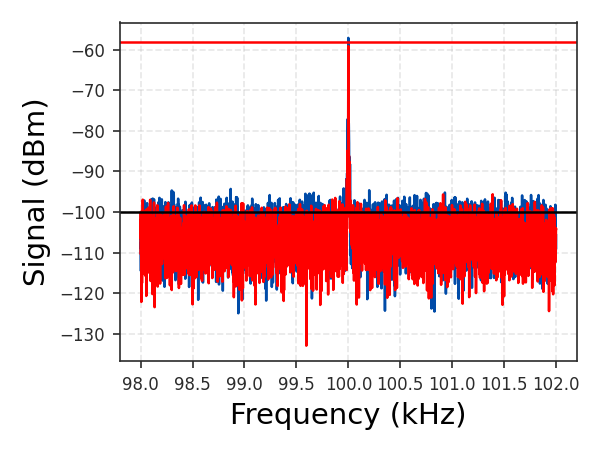

In [133]:
fix, ax = plt.subplots(1, 1, figsize=(4, 3))

signal_6_dBm=-58
noise_6_dBm=-100

FILENAME = "C:/ExperimentBlue/2021-08_photon-source/Ay_42_tracking-signal_stage4-I.txt"
with open(FILENAME) as fin:
    data = np.loadtxt(fin)
ax.plot(data[:, 0], data[:, 1])

FILENAME = "C:/ExperimentBlue/2021-08_photon-source/Ay_42_tracking-signal_stage4-Q.txt"
with open(FILENAME) as fin:
    data = np.loadtxt(fin)
ax.plot(data[:, 0], data[:, 1], color="red")

ax.axhline(signal_6_dBm, color="red", label=f"Expected signal {signal:.2f}dBm")
ax.axhline(noise_6_dBm, color="black", label=f"Expected noise {noise:.2f}dBm")

ax.set_xlabel("Frequency (kHz)")
ax.set_ylabel("Signal (dBm)")
plt.tight_layout()

In [141]:
# Next we apply a DC amplifier with low noise
# In the same measurement we add the filters, which should not affect the signal at 100kHz
gain = 22

signal_7_dBm = signal_6_dBm + gain
noise_7_dBm = W_to_dBm(
    (dBm_to_W(noise_6_dBm)) * 10**(gain/10)
)
signal_7_dBm, noise_7_dBm

(-36, -78.0)

<IPython.core.display.Javascript object>


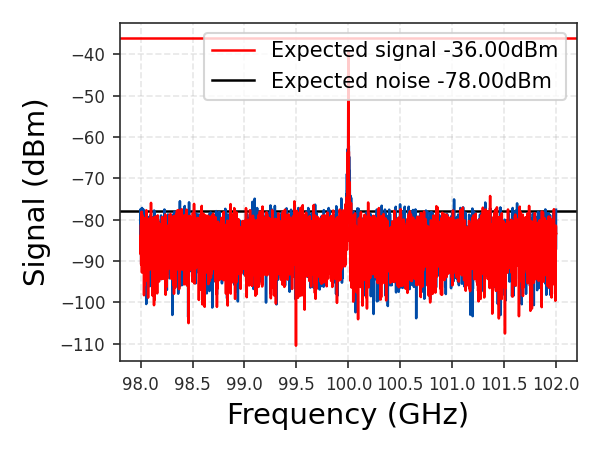

In [140]:
# Measurement
RBW = 1

noise = W_to_dBm(dBm_to_W(noise_7_dBm) * RBW) 
signal = signal_7_dBm
    
fix, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.axhline(signal, color="red", label=f"Expected signal {signal:.2f}dBm")
ax.axhline(noise, color="black", label=f"Expected noise {noise:.2f}dBm")

FILENAME = "C:/ExperimentBlue/2021-08_photon-source/Ay_42_tracking-signal_stage5-Q-A.txt"
with open(FILENAME) as fin:
    data = np.loadtxt(fin)
ax.plot(data[:, 0], data[:, 1])

FILENAME = "C:/ExperimentBlue/2021-08_photon-source/Ay_42_tracking-signal_stage6-Q-A-filter98.txt"
with open(FILENAME) as fin:
    data = np.loadtxt(fin)
ax.plot(data[:, 0], data[:, 1], color="red")

ax.set_xlabel("Frequency (GHz)")
ax.set_ylabel("Signal (dBm)")
ax.legend()
plt.tight_layout()

In [157]:
dBm_to_V(-35) / 1.1

0.00511219386536681

In [144]:
# Finally at the digitiser, we are measuring the signal. The amount of codes the signal corresponds to is
voltage = dBm_to_V(-36)
precision = 2.2 / (2**14)

voltage / precision

37.32478016249649

# Filtering

We have:
- a total capture time $Tmax=200ns$
- a transform blocksize of $N=1000$. 

Derived parameters:
- This gives a sampling interval $\Delta{T} = Tmax/N = 0.2ns$

- A maximum sampling rate $Fmax = 1/\Delta{T} = N / Tmax = 5GHz$ (more N will mean that higher frequencies can be derived)

- A frequency resolution = Fmax/N = 1/Tmax = 5MHz. The larger the capture time, the better the frequency resolution will be. This sets the lowest frequency that can be resolved

The function `fftfreq` will derive the frequency points

<IPython.core.display.Javascript object>


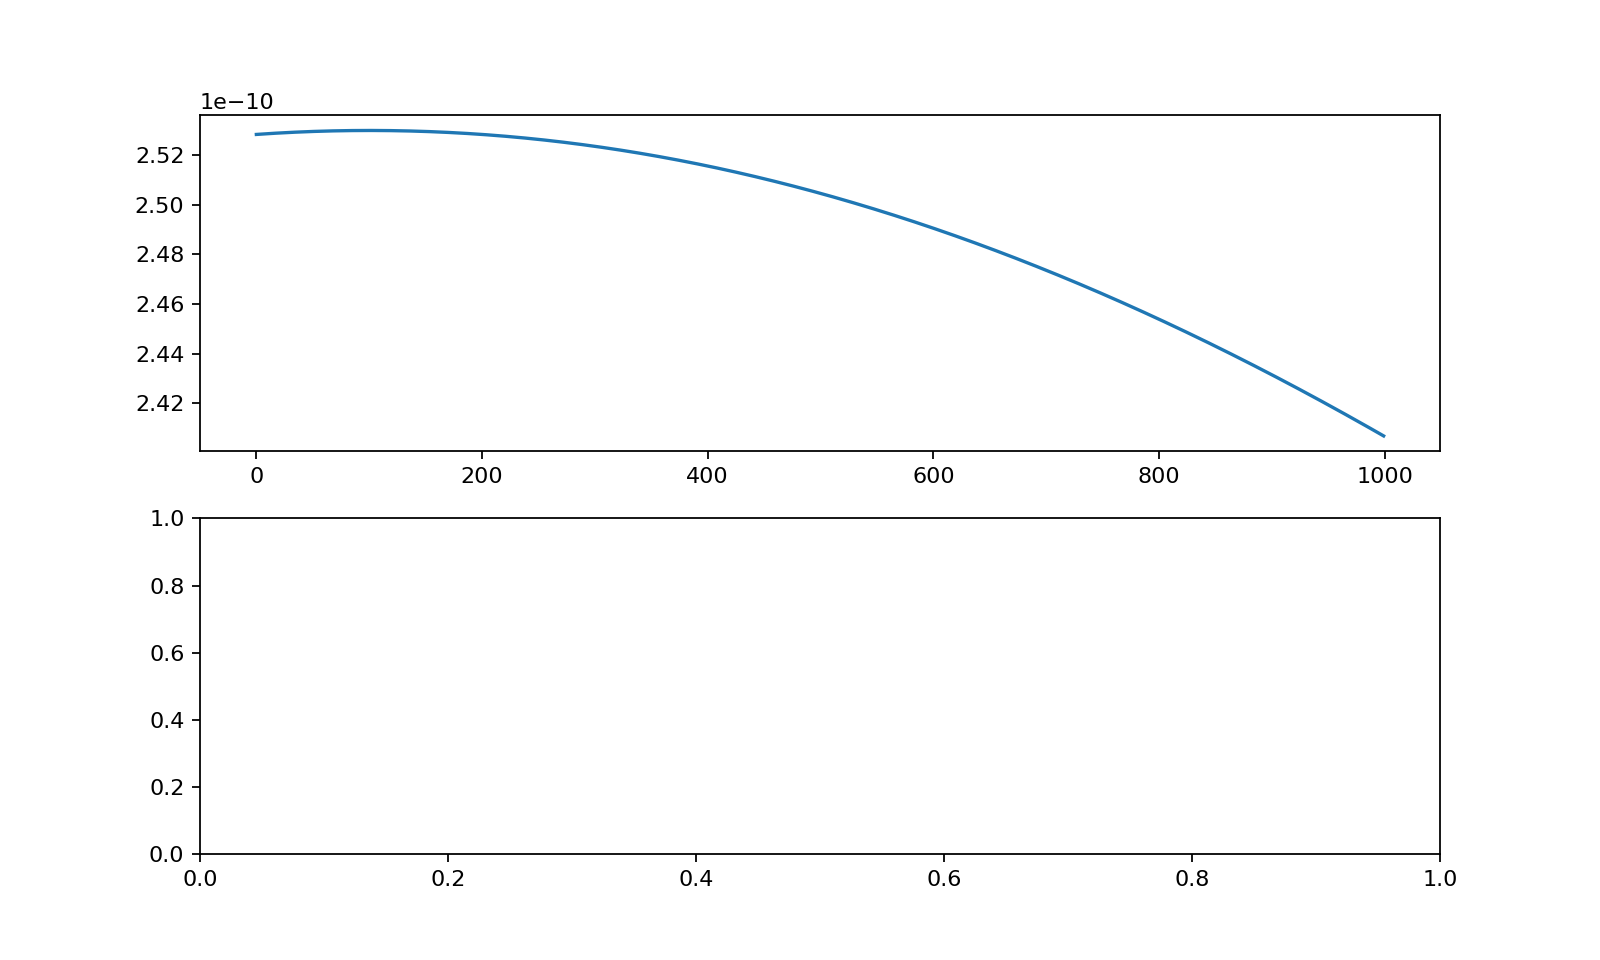

In [98]:
anal = 2 * v_qubit / (1 / T1 + T1 * (twoPi*freq_anal - twoPi*f_qubit)**2)

fig, ax = plt.subplots(2, 1, figsize=(10,6))
# ax[0].plot(freq_anal / MHz, anal)
ax[0].plot(anal)
# ax[0].plot(anal2)

<IPython.core.display.Javascript object>


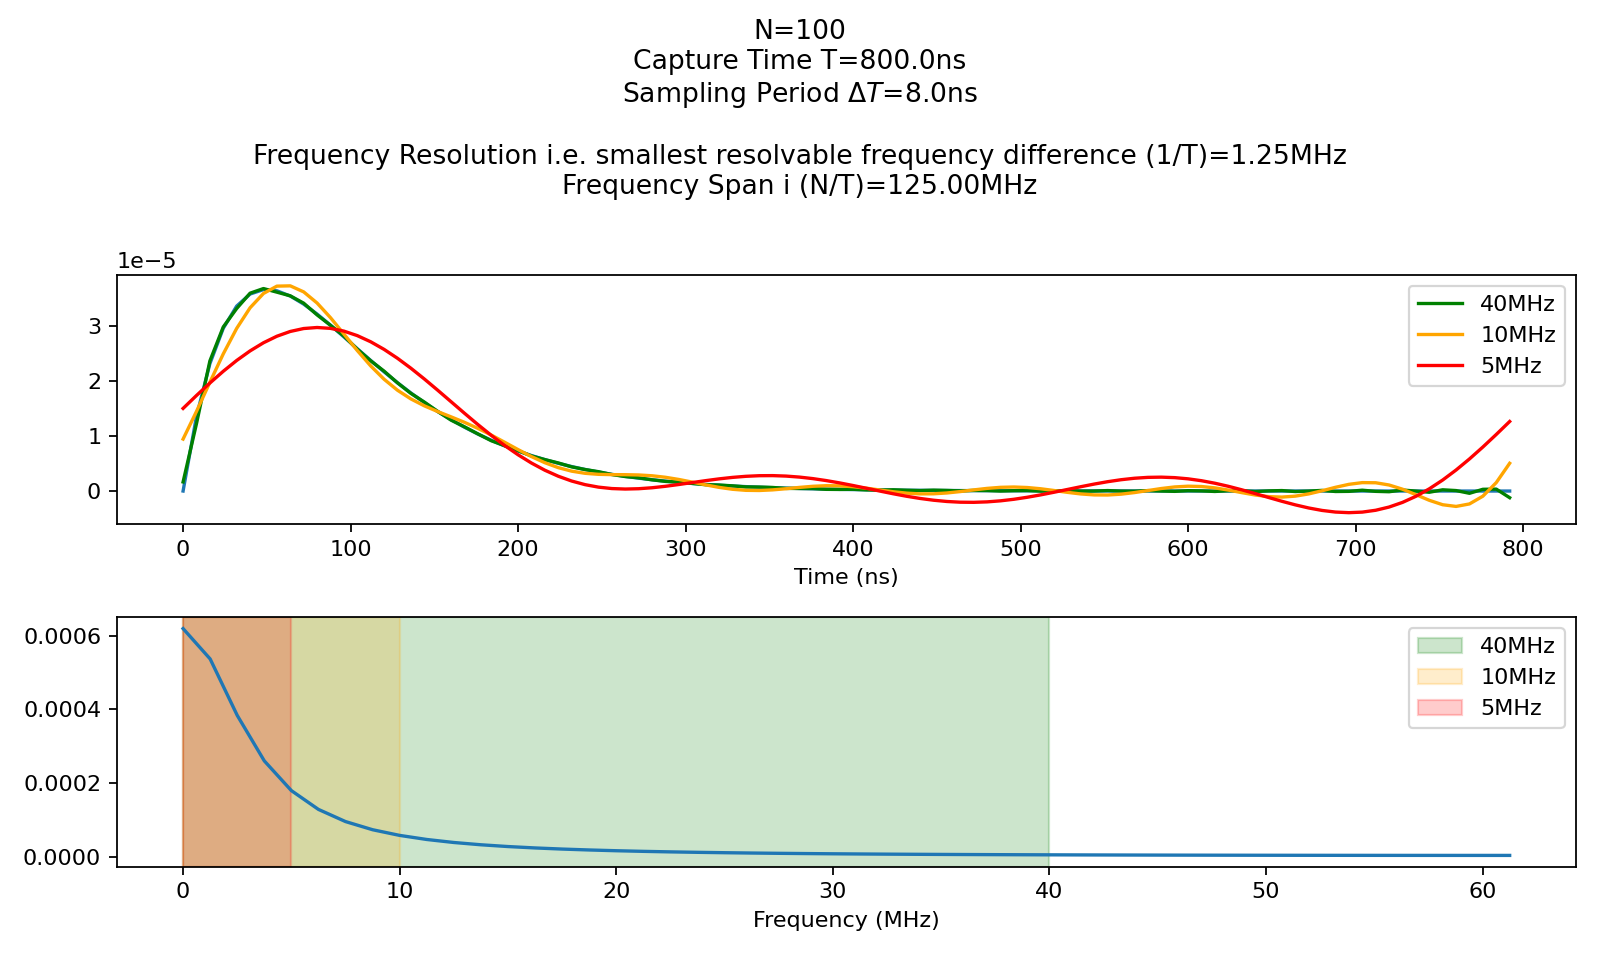

/Users/CCCP/.config/python_vi/qubit/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/CCCP/.config/python_vi/qubit/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/CCCP/.config/python_vi/qubit/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [217]:
# From notes, we have the following signal emerging from a qubit system
tmax = 800 * ns
N = 100

f_qubit = 100 * kHz # Hetrodyning
p_qubit = -40 #dBm after the signal leaves the system
T1 = 50 * ns

# Derived parametesr
v_qubit = dBm_to_V(p_qubit)
sampling_period = tmax / N

# Raw signal
time_scale = np.linspace(0, tmax, N, endpoint=False)
qubit_decay_signal = v_qubit * np.sin(2*np.pi * f_qubit* time_scale) * np.exp(-time_scale / T1)

# Brute force FFTW
POSITIVE_FREQUENCIES = int(N/2)
if N % 2:
    print("Odd FFTW")
    POSITIVE_FREQUENCIES = int(N - 1 / 2)    

freq_scale_in_hz = np.fft.fftfreq(N, d=sampling_period) # Scale by the frequency span (inverse of sampling_period)
fftw_qubit_decay_signal = fft(qubit_decay_signal)

# Analytical
# anal = 2 / (1 / T1 + T1 * (twoPi*freq_scale_in_hz - twoPi*f_qubit)**2) * 5000

fig, ax = plt.subplots(2, 1, figsize=(10,6))
ax[0].plot(time_scale / ns, qubit_decay_signal)
ax[0].set_xlabel("Time (ns)")

ax[1].plot(freq_scale_in_hz[:POSITIVE_FREQUENCIES] / MHz, np.abs(fftw_qubit_decay_signal)[:POSITIVE_FREQUENCIES])
# ax[1].plot(freq_scale_in_hz[:POSITIVE_FREQUENCIES] / MHz, np.abs(anal)[:POSITIVE_FREQUENCIES])
ax[1].set_xlabel("Frequency (MHz)");

def apply_filter(filt: float, color, label):
    # Then apply filter and transform back
    ax[1].axvspan(0, filt/MHz, color=color, alpha=0.2, label=label)
    
    filtered_list = []
    for (f, val) in zip(freq_scale_in_hz, fftw_qubit_decay_signal):
        if (np.abs(f) < filt):
            filtered_list.append(val)
        else:
            filtered_list.append(0)
            
    filtered_signal = ifft(filtered_list)
    ax[0].plot(time_scale / ns, filtered_signal, color=color, label=label)
        
apply_filter(40*MHz, "green", "40MHz")
apply_filter(10*MHz, "orange", "10MHz")
apply_filter(5*MHz, "red", "5MHz")
        
fig.suptitle(f"N={N}"+ "\n" 
             + f"Capture Time T={tmax/ns}ns" + "\n" 
             + f"Sampling Period $\Delta{{T}}$={tmax/ns/N}ns" + "\n\n" 
             + f"Frequency Resolution i.e. smallest resolvable frequency difference (1/T)={1/tmax/MHz:.2f}MHz" + "\n"
             + f"Frequency Span i (N/T)={1/sampling_period/MHz:.2f}MHz"
            );

ax[0].legend()
ax[1].legend()

plt.tight_layout();

In [1]:
%matplotlib notebook

from scipy.fft import fft, ifft, fftfreq
import matplotlib.pyplot as plt
import numpy as np

N = 1000
tmax = 200

POSITIVE_FREQUENCIES = int(N/2)
if N % 2:
    print("Odd FFTW")
    POSITIVE_FREQUENCIES = int(N - 1 / 2)    

time_in_ns = np.linspace(0, tmax, N, endpoint=False)
freq_scale_in_mhz = fftfreq(N, tmax)[:POSITIVE_FREQUENCIES] * 1000

T1 = 40
print(f"Decay rate ={1/T1 * 10**3}MHz")
sin_signal = np.sin(2 * np.pi * 0.5 * time_in_ns)
decay_signal = np.exp(-time_in_ns/T1)

fftw_signal = fft(decay_signal)
fftw_sin = fft(sin_signal)

Decay rate =25.0MHz


In [2]:
# Example with sin
# fig, ax = plt.subplots(2, 1, figsize=(10,6))
# ax[0].plot(time_in_ns, sin_signal)
# ax[0].set_xlabel("Time (ns)");
# ax[0].set_ylabel("Amplitude (au)")

# ax[1].set_xlabel("Freq (MHz)");
# ax[1].set_ylabel("Amplitude (au)")
# ax[1].plot(
#     freq_scale_in_mhz,
#     np.real(fftw_sin)[:POSITIVE_FREQUENCIES], color="blue"
# )
# ax[1].plot(
#     freq_scale_in_mhz,
#     np.imag(fftw_sin)[:POSITIVE_FREQUENCIES], color="red"
# )
# ax[1].plot(
#     freq_scale_in_mhz,
#     np.abs(fftw_sin)[:POSITIVE_FREQUENCIES], color="green"
# )